In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

from src.ksd.models import create_mixture_gaussian
from src.ksd.langevin import MALA

# Metropolis-Adjusted Langevin dynamics

In [2]:
tf.random.set_seed(0)

In [3]:
delta = 4.
n = 500
dim = 5

target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]

proposal_off = tfd.MultivariateNormalDiag(one_component_mean)
# proposal_off = tfd.MultivariateNormalDiag(0.*one_component_mean, 6*tf.ones(dim))
proposal_on = create_mixture_gaussian(dim=dim, delta=delta)

2022-01-05 10:12:45.904621: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-05 10:12:46.485003: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:db:00.0, compute capability: 7.5


In [141]:
off_samples = proposal_off.sample(n)
on_samples = proposal_on.sample(n)

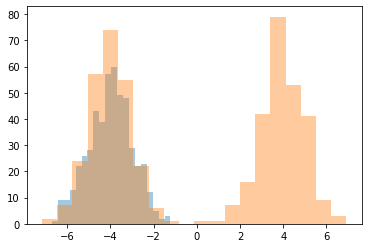

In [142]:
_ = plt.hist(off_samples.numpy()[:, 0], bins=20, label="off-target", alpha=0.4)
_ = plt.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)

In [19]:
def log_prob_fn(x):
    exp1 = tf.reduce_sum((x - one_component_mean)**2, axis=-1) # n
    exp2 = tf.reduce_sum((x + one_component_mean)**2, axis=-1) # n
    return tf.math.log(
        tf.math.exp(- 0.5 * exp1) + tf.math.exp(- 0.5 * exp2)
    )

# def log_prob_fn(x):
#     return proposal_on.log_prob(x)

# mala_off = MALA(log_prob=proposal_on.log_prob)
mala_off = MALA(log_prob=log_prob_fn)

In [144]:
steps = 2000
step_size = 0.5
x_init_off = tf.identity(off_samples)

mala_off.run(steps=steps, step_size=step_size, x_init=x_init_off)

In [145]:
# check if the hard-coded log_prob equals to the built-in fn
diff = log_prob_fn(x_init_off) - proposal_on.log_prob(x_init_off)
tf.experimental.numpy.allclose(diff, diff[0])

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [146]:
# import cProfile
# import pstats
# from pstats import SortKey

# cProfile.run('mala_off.run(steps=steps, step_size=step_size, x_init=x_init_off)', 'restats')

# p = pstats.Stats('restats')
# p.strip_dirs().sort_stats("cumtime").print_stats()

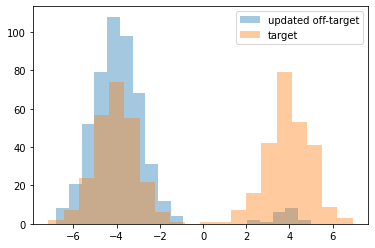

In [147]:
_ = plt.hist(mala_off.x.numpy()[-1, :, 0], bins=20, label="updated off-target", alpha=0.4)
_ = plt.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)
_ = plt.legend()

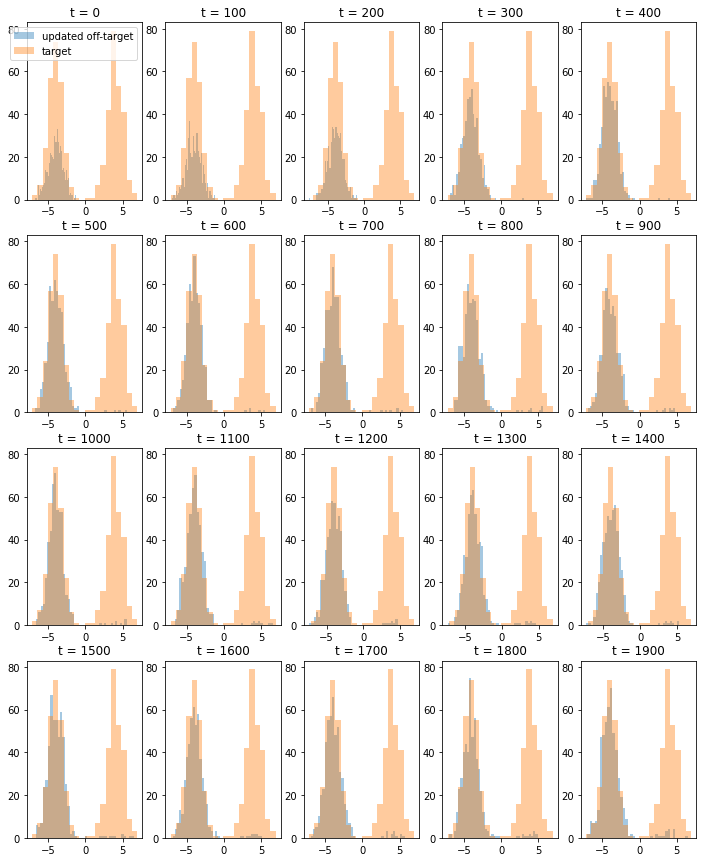

In [148]:
plot_t_step = 100 # plot every xxx steps
nplots = steps // plot_t_step
nrows = int(np.sqrt(nplots))
ncols = int(np.ceil(nplots / nrows))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*nrows, 3*ncols))

ind = 0
t = 0
for row in ax:
    for col in row:
        if ind >= nplots: break
            
        col.hist(mala_off.x.numpy()[t, :, 0], bins=40, label="updated off-target", alpha=0.4)
        col.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)
        col.set_title(f"t = {t}")
        if t == 0:
            col.legend()
        
        ind += 1
        t += plot_t_step

In [ ]:
mala_on = MALA(log_prob=proposal_on.log_prob)

x_init_on = tf.identity(on_samples)
mala_on.run(steps=steps, step_size=step_size, x_init=x_init_on)

In [ ]:
_ = plt.hist(mala_on.x.numpy()[-1, :, 0], bins=20, label="updated target", alpha=0.4)
_ = plt.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)
_ = plt.legend()

# KSD as a function of number of steps

In [14]:
from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

In [15]:
tf.random.set_seed(0)

In [16]:
kernel = IMQ(med_heuristic=True)

ksd = KSD(target=target, kernel=kernel)

nrep = 10

In [17]:
def run_mala_experiment(nrep, proposal_off, proposal_on, steps, step_size):
    ksd_df = pd.DataFrame(columns=["t", "ksd", "seed", "type"])

    iterator = trange(nrep)
    for seed in iterator:
        off_samples = proposal_off.sample(n)
        on_samples = proposal_on.sample(n)
        
        x_init_off = off_samples
        x_init_on = on_samples

        mala_off = MALA(log_prob=log_prob_fn)
        mala_off.run(steps=steps, step_size=step_size, x_init=x_init_off)

        mala_on = MALA(log_prob=log_prob_fn)
        mala_on.run(steps=steps, step_size=step_size, x_init=x_init_on)

        for t in range(steps):
            iterator.set_description(f"Time step {t+1} of {steps}")

            x_t = mala_off.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "off-target"]
            
            x_t = mala_on.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "target"]
            
    return ksd_df

In [20]:
ksd_df = run_mala_experiment(
    nrep=nrep, 
    proposal_off=proposal_off, 
    proposal_on=proposal_on, 
    steps=2000, 
    step_size=0.5)

  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
# ksd_df = pd.read_csv("res/mala.csv")
ksd_df.to_csv("res/mala_0.5.csv", index=False)

<AxesSubplot:xlabel='t', ylabel='ksd'>

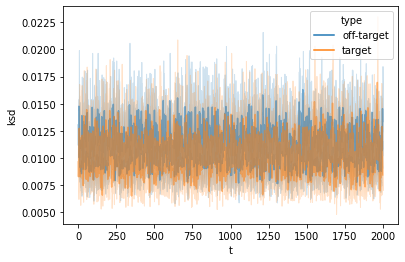

In [26]:
sns.lineplot(data=ksd_df, x="t", y="ksd", hue="type", alpha=0.5)

# Check if the test controls p-value

In [ ]:
from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

In [ ]:
tf.random.set_seed(0)

In [ ]:
kernel = IMQ(med_heuristic=True)

ksd = KSD(target=target, kernel=kernel)

nrep = 10